In [1]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

from pathlib import Path
import os
os.environ['WANDB_DISABLED']='true'

In [ ]:
# from huggingface_hub import hf_hub_download


# hf_dataset_identifier = "sayakpaul/ucf101-subset"
# filename = "UCF101_subset.tar.gz"
# file_path = hf_hub_download(
#     repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
# )

# dataset_root_path = "VideoMAE/UCF101_subset"
# import pathlib
# dataset_root_path = pathlib.Path(dataset_root_path)


# video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
# video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
# video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
# video_total = video_count_train + video_count_val + video_count_test
# print(f"Total videos: {video_total}")


# all_video_file_paths = (
#     list(dataset_root_path.glob("train/*/*.avi"))
#     + list(dataset_root_path.glob("val/*/*.avi"))
#     + list(dataset_root_path.glob("test/*/*.avi"))
# )
# all_video_file_paths[:5]


# class_labels = sorted({str(path).split("/")[3] for path in all_video_file_paths})
# label2id = {label: i for i, label in enumerate(class_labels)}
# id2label = {i: label for label, i in label2id.items()}

# print(f"Unique classes: {list(label2id.keys())}.")

In [2]:
from pathlib import Path
import datasets, os
import random


target_path = "charades_HF"
datasets.config.DOWNLOADED_DATASETS_PATH = Path(target_path)
dataset = datasets.load_dataset("HuggingFaceM4/charades")

label2id = {label: i for i, label in enumerate(list(range(157)))}
id2label = {i: label for label, i in label2id.items()}
dataset_root_path = 'charades_HF/extracted/b1114f723459b513122220bfcf30b1b7423f65be17a11b936a8d29dbf1d83eba/Charades_v1'

def get_path_and_label(dataset, video_root, split='train'):
    paths = [
        os.path.join(video_root, video_info['video_id']+'.mp4')
        for video_info in dataset[split]
    ]
    labels = [video_info['labels'] for video_info in dataset[split]]

    return paths, labels

train_path, train_labels = get_path_and_label(dataset, dataset_root_path)
test_path, test_labels = get_path_and_label(dataset, dataset_root_path, split='test')

zipped_train = list(zip(train_path, train_labels))

random.seed(37)
random.shuffle(zipped_train)

split_point = int(len(zipped_train)*.9)
zipped_train, zipped_eval = zipped_train[:split_point], zipped_train[split_point: ]

train_path, train_labels = zip(*zipped_train)
eval_path, eval_labels = zip(*zipped_eval)


len(train_path), len(train_labels), len(eval_path), len(eval_labels), len(test_path), len(test_labels)

No config specified, defaulting to: charades/default
Found cached dataset charades (/home/jahid/.cache/huggingface/datasets/HuggingFaceM4___charades/default/0.0.0/c37f23dc5fc4916d250afb58fe981c5a68cfe30d9f78bc6d23a74ffa157618f7)


  0%|          | 0/2 [00:00<?, ?it/s]

(7186, 7186, 799, 799, 1863, 1863)

In [3]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [6]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)


# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)


import torch
from pytorchvideo_data import LabeledVideoDataset


def make_one_hot_label(label):
    labels = torch.zeros(len(id2label), dtype=torch.float32)
    labels[label] = 1.0
    return labels


# (List[Tuple[str, Optional[dict]]])
train_labeled_video_paths = [
    (v_path, {"label": make_one_hot_label(v_label)})
    for (v_path, v_label) in zip(train_path, train_labels)
]
eval_labeled_video_paths = [
    (v_path, {"label": make_one_hot_label(v_label)})
    for (v_path, v_label) in zip(eval_path, eval_labels)
]

train_dataset = LabeledVideoDataset(
    labeled_video_paths=train_labeled_video_paths,
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    video_sampler=torch.utils.data.RandomSampler,
    transform=train_transform,
    decode_audio=False,
    decoder="pyav",
)

eval_dataset = LabeledVideoDataset(
    labeled_video_paths=eval_labeled_video_paths,
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    video_sampler=torch.utils.data.RandomSampler,
    transform=val_transform,
    decode_audio=False,
    decoder="pyav",
)

In [7]:
len(train_dataset._labeled_videos), train_dataset._labeled_videos

(7186,
 [('charades_HF/extracted/b1114f723459b513122220bfcf30b1b7423f65be17a11b936a8d29dbf1d83eba/Charades_v1/PSSJ8.mp4',
   {'label': tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])}),
  ('charades_HF/extracted/b1114f723459b513122220bfcf30b1b7423f65be17a11b936a8d29dbf1d83eba/Charades_v1/3EIRZ.mp4',
   {'label': t

In [8]:
for d in train_dataset:
    break

d.keys(), d['video'].shape

(dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label']),
 torch.Size([3, 16, 224, 224]))

In [9]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [10]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    # print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name 2RJF6.mp4
video_index 1117
clip_index 0
aug_index 0
label tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


We can also visualize the preprocessed videos for easier debugging.

In [11]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

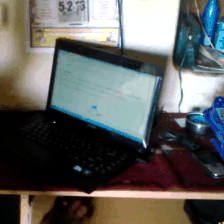

In [12]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [13]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-charades"
num_epochs = 4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [14]:
import evaluate
metric = evaluate.load("accuracy")

In [15]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [16]:
import torch

def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.stack([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [17]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [18]:
train_results = trainer.train()

  0%|          | 0/896 [00:00<?, ?it/s]

ValueError: only one element tensors can be converted to Python scalars

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [ ]:
trainer.evaluate(test_dataset)

In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

In [ ]:
trainer.push_to_hub()

Now that our model is trained, let's use it to run inference on a video from `test_dataset`.

## Inference

Let's load the trained model checkpoint and fetch a video from `test_dataset`.

In [ ]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [ ]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

We then prepare the video as a `torch.Tensor` and run inference.

In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
logits = run_inference(trained_model, sample_test_video["video"])

We can now check if the model got the prediction right.

In [ ]:
display_gif(sample_test_video["video"])

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

And it looks like it got it right!

You can also use this model to bring in your own videos. Check out [this Space](https://huggingface.co/spaces/sayakpaul/video-classification-ucf101-subset) to know more. The Space will also show you how to run inference for a single video file.

<br><div align=center>
    <img src="https://i.ibb.co/7nW4Rkn/sample-results.gif" width=700/>
</div>

## Next steps

Now that you've learned to train a well-performing video classification model on a custom dataset here is some homework for you:

* Increase the dataset size: include more classes and more samples per class.
* Try out different hyperparameters to study how the model converges.
* Analyze the classes for which the model fails to perform well.
* Try out a different video encoder.

Don't forget to share your models with the community =)